# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 23.11.2019

Мягкий дедлайн: 8:00MSK 01.12.2019

Жесткий дедлайн: 23:59MSK 02.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
from sklearn.datasets import load_boston

In [6]:
boston = load_boston()

In [7]:
X = boston["data"]
y = boston["target"]

In [8]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [9]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.56887354691718

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [10]:
from tqdm import tqdm

In [11]:
# X[:5]
# samples_indices = np.random.randint(X.shape[0], size=(1000, X.shape[0]))
# samples_indices[0] -= 200
# samples_indices.astype(bool)
# X[samples_indices[0], :].shape
# y[samples_indices[0]]

In [12]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    obj_amount = X.shape[0]
    
    total_obj_usage = np.zeros(obj_amount)
    predicts = np.zeros(obj_amount)
    sqr_predicts = np.zeros(obj_amount)
    errors = np.zeros(obj_amount)
    
    samples_indices = np.random.randint(obj_amount, size=(num_runs, obj_amount))
#     for i in tqdm(range(num_runs)):
    for i in range(num_runs):
        cur_sample_ind = samples_indices[i]
        X_j = X[cur_sample_ind, :]
        y_j = y[cur_sample_ind]
        a_j = regressor.fit(X_j, y_j)
        
        if_used = np.ones(obj_amount, dtype=bool)
        if_used[list(set(samples_indices[i]))] = 0
        T_j = X[if_used, :]
        y_T_j = y[if_used]

        total_obj_usage[if_used] += 1
        predicts[if_used] += a_j.predict(T_j)
        sqr_predicts[if_used] += (np.square(a_j.predict(T_j)))
        errors[if_used] += np.square(a_j.predict(T_j) - y_T_j)
        
    bias_mask = total_obj_usage.astype(bool)
    mean_pred = predicts[bias_mask] / total_obj_usage[bias_mask]
    bias = np.mean( np.square(mean_pred - y[bias_mask]) )
    
    variance = sqr_predicts[bias_mask] / total_obj_usage[bias_mask]
    variance -= np.square(predicts[bias_mask] / total_obj_usage[bias_mask])
    variance = np.mean(variance)
    
    error = np.mean( errors[bias_mask] / total_obj_usage[bias_mask] )
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [14]:
bias, variance, error = compute_biase_variance(LinearRegression(), X, y)
print("Linear regression: \nBias: %.2f,\nVariance: %.2f,\nError: %.2f,\nDifference between error and bias+variance: %.1f" % (bias, variance, error, error - bias - variance), end='\n')

bias, variance, error = compute_biase_variance(DecisionTreeRegressor(), X, y)
print("Decision tree: \nBias: %.2f,\nVariance: %.2f,\nError: %.2f,\nDifference between error and bias+variance: %.1f" % (bias, variance, error, error - bias - variance), end='\n')

bias, variance, error = compute_biase_variance(RandomForestRegressor(), X, y)
print("Random forest: \nBias: %.2f,\nVariance: %.2f,\nError: %.2f,\nDifference between error and bias+variance: %.1f" % (bias, variance, error, error - bias - variance), end='\n')


Linear regression: 
Bias: 23.67,
Variance: 0.91,
Error: 24.59,
Difference between error and bias+variance: 0.0
Decision tree: 
Bias: 10.33,
Variance: 13.02,
Error: 23.35,
Difference between error and bias+variance: 0.0


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random forest: 
Bias: 10.61,
Variance: 3.40,
Error: 14.02,
Difference between error and bias+variance: -0.0


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__ Конечно совпадают! Семинар 8:
1. Лин Рег
> Семинар 8:
> Мы выяснили, что линейные модели имеют маленькое смещение, когда истинная зависимость в данных также линейна, и большое смещение, если это не так. 
> Мы получили, что если шум в ответах небольшой, то и разброс модели будет небольшой.

Заметим то, что это как раз то, что мы получили. Большое смещение и небольшой разброс с минимальным шумом.

2. Решающее дерево:
> Всё тот же семинар 8. Интуитивно понятно, что поскольку для любой выборки можно построить дерево, имеющую нулевую ошибку на обучении, то смещение решающего дерева будет небольшое для любой истинной зависимости f(x). Разброс, наоборот, будет большой, потому что при малом изменении в выборке мы можем получить совершенно другое решающее дерево.

Аналогично результаты у нас получились такие же. Относительно большой разброс и маленькое смещение.

3. Лес:
> Существуют способы уменьшить разброс алгоритма. Наиболее известный из них — бэггинг.

Ровно то же, что и у нас - разброс уменьшился, смещение осталось примерно тем же.

__3. (1 балл)__
Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ 
> Из лекции: " Следует отметить, что рассмотренный нами пример не очень применим на практике, поскольку мы сделали предположение о некоррелированности ошибок, что редко выполняется. "

Очевидно, что сгенерированные нами выборки кореллируют между собой причме довольно сильно (так как в принципе они генерируются из одной и той же выборки). Поэтому понятно, почему в нашем случае это не сильно выполняется.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__4. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)
    samples_indices = np.random.randint(X_train.shape[0], size=(num_runs, X_train.shape[0]))
    for i in range(num_runs):
        cur_sample_ind = samples_indices[i]
        X_j = X_train[cur_sample_ind, :]
        y_j = y_train[cur_sample_ind]
        a_j = regressor.fit(X_j, y_j)
        
        predicts = a_j.predict(X_test)
        plt.scatter(range(num_test_objects), predicts, c='pink')
    plt.scatter(range(num_test_objects), y_test, c='k')
    plt.xlabel("Номера объектов тестовой выборки")
    plt.ylabel("Предсказания")
    plt.title(title)
    

__5. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


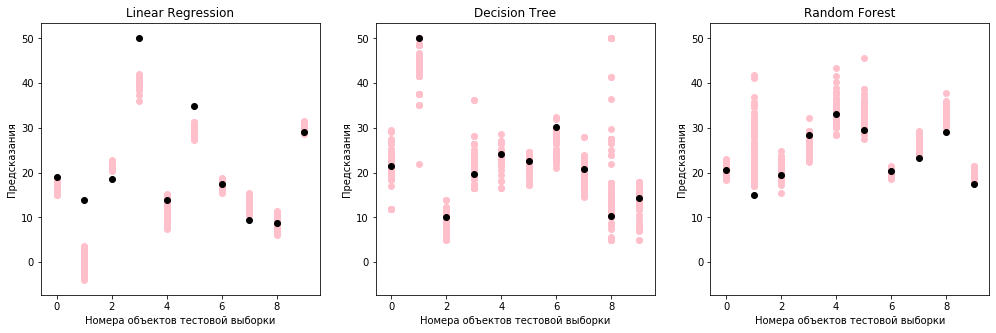

In [17]:
figure = plt.figure(figsize=(17, 5))
ax = plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, title="Linear Regression")
plt.subplot(1, 3, 2, sharex=ax, sharey=ax)
plot_predictions(DecisionTreeRegressor(), X, y, title="Decision Tree")
plt.subplot(1, 3, 3, sharex=ax, sharey=ax)
plot_predictions(RandomForestRegressor(), X, y, title="Random Forest")

__6. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ 
1. __Linear Regression:__ заметим прежде всего, что разброс очень маленький -- полосы довольно короткие -- то есть сильно сгруппированы между собой точки. Очевидно, что смещение, то есть отдаление черной точки от розовых -- большое (так как в идеале оно должно быть посерёдке)
2. __Decision Tree:__ здесь наоборот полосы сильно разрежены, а значит, разброс сильно велик (должен быть). В это же время черные точки находятся почти в центре этих розовых полос, что дает нам понять, что смещение довольно маленькое должно быть.
3. __Random Forest:__ сравнивая с первым и вторым графиком тут разброс примерно по середине между ними... То есть он не сильно большой, как в случае дерева, но и не такой маленький как в случае линейной регрессии. Со смещением ситуация выглядит больше похожей на дерево, то есть черные точки находятся ближе к середине полос. Другими словами если смотреть на смещение, то лес больше выглядит похожим на дерево, чем на лин рег.

### Изменение bias и variance при изменении гиперпараметров

__7. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [18]:
depth_bias = []
depth_variance = []
am_feat_bias = []
am_feat_variance = []


for depth in tqdm(range(1, 11)):
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_depth=depth), X, y)
    depth_bias.append(bias)
    depth_variance.append(variance)
for am_features in tqdm(range(1, X.shape[1] + 1)):
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_features=am_features), X, y)
    am_feat_bias.append(bias)
    am_feat_variance.append(variance)

100%|██████████| 13/13 [00:26<00:00,  2.03s/it]


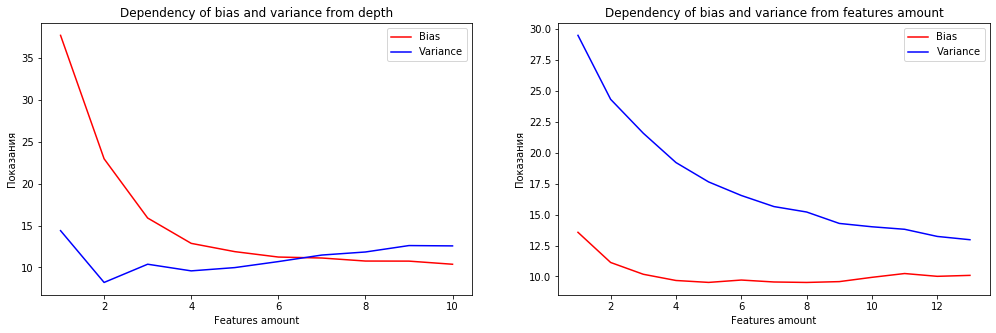

In [19]:
figure = plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 11), depth_bias, c='r', label="Bias")
plt.plot(np.arange(1, 11), depth_variance, c='b', label="Variance")
plt.legend()

plt.xlabel("Features amount")
plt.ylabel("Показания")
plt.title("Dependency of bias and variance from depth")

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, X.shape[1] + 1), am_feat_bias, c='r', label="Bias")
plt.plot(np.arange(1, X.shape[1] + 1), am_feat_variance, c='b', label="Variance")
plt.legend()

plt.xlabel("Features amount")
plt.ylabel("Показания")
plt.title("Dependency of bias and variance from features amount")

plt.show()

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [20]:
from xgboost import XGBRegressor

In [32]:
forest_bias = []
forest_variance = []
boosting_bias = []
boosting_variance = []

for estimators in tqdm(2 ** np.arange(1, 12)):
    bias, variance, error = compute_biase_variance(RandomForestRegressor(n_estimators=estimators), X, y, num_runs=100)
    forest_bias.append(bias)
    forest_variance.append(variance)

    bias, variance, error = compute_biase_variance(XGBRegressor(n_estimators=estimators), X, y, num_runs=100)
    boosting_bias.append(bias)
    boosting_variance.append(variance)

  0%|          | 0/11 [00:00<?, ?it/s]

[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

  9%|▉         | 1/11 [00:01<00:10,  1.00s/it]

[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

 18%|█▊        | 2/11 [00:02<00:10,  1.17s/it]

[02:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[02:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

 27%|██▋       | 3/11 [00:05<00:13,  1.70s/it]

[02:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

 36%|███▋      | 4/11 [00:10<00:19,  2.81s/it]

[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

 45%|████▌     | 5/11 [00:21<00:30,  5.08s/it]

[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[02:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

 55%|█████▍    | 6/11 [00:40<00:46,  9.36s/it]

[02:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[02:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

 64%|██████▎   | 7/11 [01:19<01:12, 18.10s/it]

[02:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[02:25:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:25:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

 73%|███████▎  | 8/11 [02:36<01:47, 35.77s/it]

[02:27:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:27:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:27:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:27:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:27:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:27:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:27:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:27:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:27:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[02:28:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:28:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

 82%|████████▏ | 9/11 [05:09<02:22, 71.14s/it]

[02:32:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[02:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

 91%|█████████ | 10/11 [10:18<02:22, 142.34s/it]

[02:42:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[02:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

100%|██████████| 11/11 [20:37<00:00, 112.51s/it]


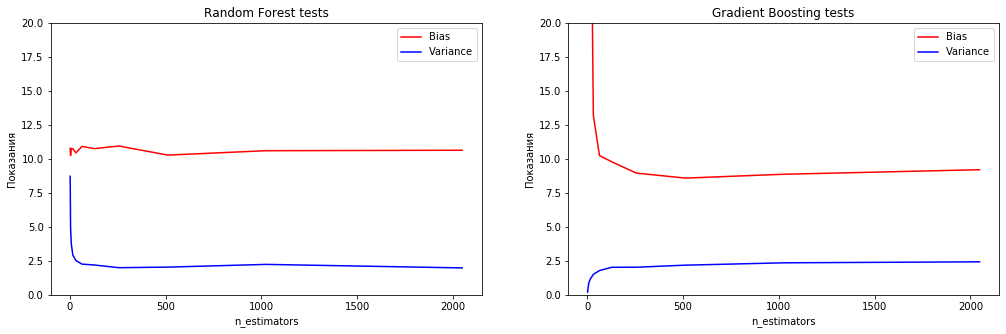

In [33]:
figure = plt.figure(figsize=(17, 5))
ax = plt.subplot(1, 2, 1, sharex=ax, sharey=ax)
plt.plot(2 ** np.arange(1, 12), forest_bias, c='r', label="Bias")
plt.plot(2 ** np.arange(1, 12), forest_variance, c='b', label="Variance")
plt.legend()

plt.xlabel("n_estimators")
plt.ylabel("Показания")
plt.title("Random Forest tests")

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.plot(2 ** np.arange(1, 12), boosting_bias, c='r', label="Bias")
plt.plot(2 ** np.arange(1, 12), boosting_variance, c='b', label="Variance")
plt.legend()

plt.xlabel("n_estimators")
plt.ylabel("Показания")
plt.title("Gradient Boosting tests")
plt.ylim((0, 20))

plt.show()

__3. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
1. __Bias:__
Изначально у леса смещение меньше чем у бустинга, так как алгоритм в принципе так построен, что мы ориентируемся на подстройку под выборку. Однако у бустинга (я ограничил график для того чтобы было более показательно и информативно) вначале слишком завышен байас по причине, наверное, того, что при маленьком количестве эстимейтеров просто композиция не сильна, однако со увеличением этого гиперпараметра мы можем заметить, что бустинг начинает "выигрывать" у леса, уменьшая байас.

2. __Variance:__
Очевидно, что у леса с увеличением количества деревьев рахброс начинает уменьшаться по причине того, что мы все лучше и лучше подстраиваемся под выборку, когда у бустинга не совсем так при достаточно заметном увеличении гиперпараметра...